In [2]:
# Cell 1 – libraries
import sys
import os
import numpy as np
from numpy import exp, log, sqrt
from scipy.stats import norm, qmc
from tqdm.auto import trange
import matplotlib.pyplot as plt

# Add the project root directory to Python path
sys.path.append('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM')

# Import the simulate_hhk_spot function from src module
from src.simulate_hhk_spot import simulate_hhk_spot, theoretical_moments, bootstrap_moments

import scienceplots
from scipy.stats import gaussian_kde

# Set the science plot style
plt.style.use(['science', 'no-latex'])

---
# Underlying Simulation from "Modelling spikes and pricing swing options in electricity markets" Hambly et al. (2009)

**Model (Hambly–Howison–Kluge)**  
- Spot: $S_t=\exp\bigl(f(t)+X_t+Y_t\bigr)$.  
- Diffusive OU: $\displaystyle dX_t=-\alpha X_t\,dt+\sigma\,dW_t$.  
- Spike OU: $\displaystyle dY_t=-\beta Y_t\,dt+J_t\,dN_t,\;N_t\sim\mathrm{Poisson}(\lambda),\;J_i\stackrel{\mathrm{iid}}{\sim}\mathrm{Exp}(1/\mu_J).$  
- Exact solutions:  
  $$
    X_t=X_0e^{-\alpha t}+\sigma\int_{0}^{t}e^{-\alpha(t-s)}\,dW_s,\quad
    Y_t=Y_0e^{-\beta t}+\sum_{i=1}^{N_t}e^{-\beta(t-\tau_i)}J_{\tau_i}.
  $$

**Simulation steps**  
1. **Time grid**: $\Delta t=T/n_{\rm steps}$,  $t_k=k\Delta t$,  $k=0,\dots,n_{\rm steps}$.  
2. **OU update** via scrambled Sobol quasi-normals $z_k$:
   $$
     X_{k}
     =e^{-\alpha\Delta t}X_{k-1}
     +\sqrt{\tfrac{\sigma^2}{2\alpha}(1-e^{-2\alpha\Delta t})}\;z_{k-1}.
   $$
3. **Jump‐OU** (antithetic):
   - Draw Poisson counts $c_k\sim\mathrm{Pois}(\lambda\Delta t)$ per half-pair.
   - For each jump time $u_j\in[0,\Delta t]$ and uniforms $V,\bar V$, set
     $J_1=-\mu_J\ln V,\;J_2=-\mu_J\ln(1-V)$.
   - Accumulate  
     $$
       Y_k=e^{-\beta\Delta t}Y_{k-1}
       +\sum_{j=1}^{c_k}e^{-\beta(\Delta t-u_j)}J_j
       \quad\text{(paired antithetic across paths).}
     $$
4. **Spot**: $S_k=\exp\bigl(f(t_k)+X_k+Y_k\bigr)\,$.  

In [3]:
"""
    Hambly–Howison–Kluge spot model with antithetic variance reduction.
    
    Note: Antithetic variance reduction is only applied when n_paths >= 2 and n_paths is even.
    For single path generation (n_paths=1), standard simulation is used.

    Returns
    -------
    t : (n_steps+1,) ndarray     time grid
    S : (n_paths, n_steps+1)     spot price paths
    X : (n_paths, n_steps+1)     diffusive OU paths
    Y : (n_paths, n_steps+1)     spike (jump‑OU) paths
"""
stochastic_process_params = {
    'S0': 1.0,          # Initial spot price
    'T': 1.0,           # Time horizon
    'n_steps': 252,     # Number of time steps
    'n_paths': 16384*4, # Number of paths (should be even for antithetic variance reduction)
    'alpha': 12.0,      # Mean reversion speed
    'sigma': 1.2,       # Volatility of the diffusive component
    'beta': 150.0,      # Mean reversion level for the OU process
    'lam': 6.0,         # Intensity of the jump process
    'mu_J': 0.3,        # Mean of the jump size distribution
    'f': lambda t: 0.0,  # Function for the drift term (can be a constant or a function of time)
}
# Simulate the HHK spot model
t, S, X, Y = simulate_hhk_spot( 
    **stochastic_process_params,
    seed=1,
)
print(f'Simulation Completed')

Simulation Completed


**Moments of $X_T$ (OU)**  
$$
  m_X = E[X_T] = X_0e^{-\alpha T}, 
  \quad
  v_X = \mathrm{Var}[X_T] = \frac{\sigma^2}{2\alpha}\bigl(1-e^{-2\alpha T}\bigr).
$$

**Moments of $Y_T$ (spike OU)**  
$$
  m_Y = E[Y_T]
    =Y_0e^{-\beta T} + \frac{\lambda\mu_J}{\beta}\bigl(1-e^{-\beta T}\bigr),
  \quad
  v_Y = \mathrm{Var}[Y_T]
    =\frac{\lambda\mu_J^2}{\beta}\bigl(1-e^{-2\beta T}\bigr).
$$

**Log‐spot MGF**  
Let $Z_T=f(T)+X_T+Y_T$.  Then
$$
  M(\theta)=E[e^{\theta Z_T}]
  =\exp\Bigl(\theta f(T)+\theta m_X+\tfrac12\theta^2v_X\Bigr)
   \;\times\;
   \Bigl(\tfrac{1-\theta\mu_J e^{-\beta T}}{1-\theta\mu_J}\Bigr)^{\!\lambda/\beta}.
$$

**Spot moments**  
$$
  E[S_T]=M(1),\quad
  E[S_T^2]=M(2),\quad
  \mathrm{Var}[S_T]=M(2)-M(1)^2.
$$


In [4]:
# Moments of S(T)
mean_results, std_results = bootstrap_moments(S[:, -1])

desired_keys = ['S0','T','alpha','sigma','beta','lam','mu_J','f']
subset_params = {key: stochastic_process_params[key] for key in desired_keys if key in stochastic_process_params}
mZ, sZ, mX, sX, mY, sY = theoretical_moments(**subset_params)

print('> S(T) moments:')
print(f'E[S(T)] = {mean_results[0]:.4f} (empirical), {mZ:.4f} (analytical), bounds: [{mean_results[1]:.4f}, {mean_results[2]:.4f}]')
print(f'Std[S(T)] = {std_results[0]:.4f} (empirical), {sZ:.4f} (analytical), bounds: [{std_results[1]:.4f}, {std_results[2]:.4f}]')

# Moments of X(T)
mean_results_X, std_results_X = bootstrap_moments(X[:, -1])

print('\n> X(T) moments:')
print(f'E[X(T)] = {mean_results_X[0]:.4f} (empirical), {mX:.4f} (analytical), bounds: [{mean_results_X[1]:.4f}, {mean_results_X[2]:.4f}]')
print(f'Std[X(T)] = {std_results_X[0]:.4f} (empirical), {sX:.4f} (analytical), bounds: [{std_results_X[1]:.4f}, {std_results_X[2]:.4f}]')

# Moments of Y(T)
mean_results_Y, std_results_Y = bootstrap_moments(Y[:, -1])

print('\n> Y(T) moments:')
print(f'E[Y(T)] = {mean_results_Y[0]:.4f} (empirical), {mY:.4f} (analytical), bounds: [{mean_results_Y[1]:.4f}, {mean_results_Y[2]:.4f}]')
print(f'Std[Y(T)] = {std_results_Y[0]:.4f} (empirical), {sY:.4f} (analytical), bounds: [{std_results_Y[1]:.4f}, {std_results_Y[2]:.4f}]')

> S(T) moments:
E[S(T)] = 1.0455 (empirical), 1.0453 (analytical), bounds: [1.0434, 1.0476]
Std[S(T)] = 0.2766 (empirical), 0.2775 (analytical), bounds: [0.2734, 0.2799]

> X(T) moments:
E[X(T)] = 0.0000 (empirical), 0.0000 (analytical), bounds: [-0.0019, 0.0019]
Std[X(T)] = 0.2449 (empirical), 0.2449 (analytical), bounds: [0.2436, 0.2462]

> Y(T) moments:
E[Y(T)] = 0.0122 (empirical), 0.0120 (analytical), bounds: [0.0117, 0.0126]
Std[Y(T)] = 0.0604 (empirical), 0.0600 (analytical), bounds: [0.0579, 0.0631]


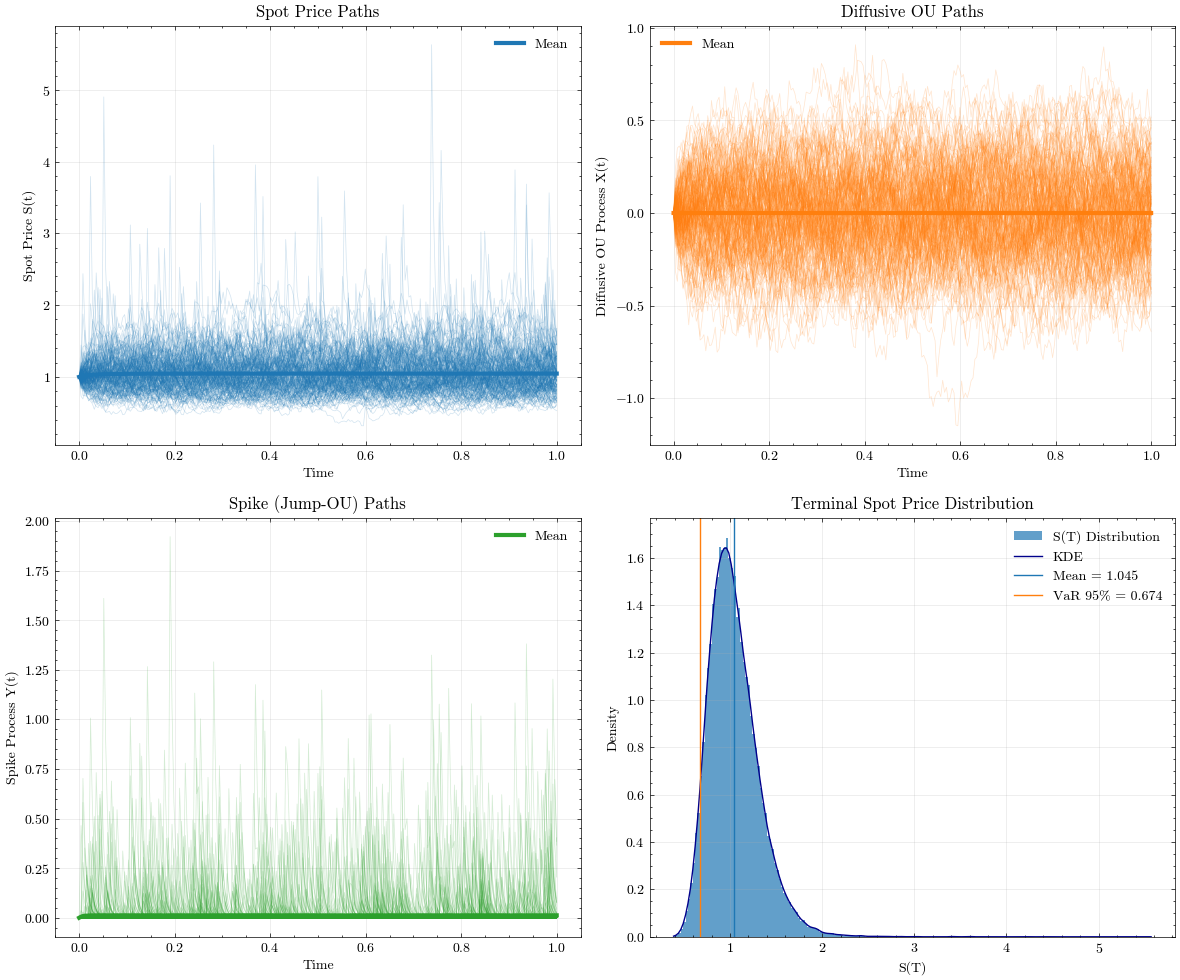

Simulation Summary:
Number of paths: 65,536
Number of time steps: 253
Time horizon: 1.0 years

Terminal Statistics S(T):
Mean: 1.0455
Std: 0.2766
Min: 0.3878
Max: 5.5692
VaR 95%: 0.6744
VaR 99%: 0.5683


In [5]:
# Plot the simulated spot price paths - Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:blue']
n_plot_paths = 200

# Plot data for S, X, Y with means
for i, (data, label, ylabel) in enumerate([(S, 'Spot Price Paths', 'Spot Price S(t)'), 
                                           (X, 'Diffusive OU Paths', 'Diffusive OU Process X(t)'), 
                                           (Y, 'Spike (Jump-OU) Paths', 'Spike Process Y(t)')]):
    ax = axes.flat[i]
    for j in range(min(n_plot_paths, data.shape[0])):
        ax.plot(t, data[j, :], color=colors[i], alpha=0.2, linewidth=0.5)
    ax.plot(t, np.mean(data, axis=0), color=colors[i], linewidth=3, label='Mean', alpha=1.0)
    ax.set_xlabel('Time')
    ax.set_ylabel(ylabel)
    ax.set_title(label)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot S(T) distribution
ax = axes[1, 1]
S_T = S[:, -1]
ax.hist(S_T, bins=200, density=True, alpha=0.7, color=colors[3], label='S(T) Distribution')
kde = gaussian_kde(S_T)
x_kde = np.linspace(S_T.min(), S_T.max(), 200)
ax.plot(x_kde, kde(x_kde), color='darkblue', linewidth=1, label='KDE')
S_T_mean = np.mean(S_T)
var_95 = np.percentile(S_T, 5)
ax.axvline(S_T_mean, color='tab:blue', linestyle='-', linewidth=1, label=f'Mean = {S_T_mean:.3f}')
ax.axvline(var_95, color='tab:orange', linestyle='-', linewidth=1, label=f'VaR 95% = {var_95:.3f}')
ax.set_xlabel('S(T)')
ax.set_ylabel('Density')
ax.set_title('Terminal Spot Price Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Simulation Summary:\nNumber of paths: {S.shape[0]:,}\nNumber of time steps: {S.shape[1]}\nTime horizon: {t[-1]:.1f} years")
print(f"\nTerminal Statistics S(T):\nMean: {S_T_mean:.4f}\nStd: {np.std(S_T):.4f}\nMin: {S_T.min():.4f}\nMax: {S_T.max():.4f}\nVaR 95%: {var_95:.4f}\nVaR 99%: {np.percentile(S_T, 1):.4f}")

---
# For Monthly Swing Options

Simulation Completed


> S(T) moments:
E[S(T)] = 1.0413 (empirical), 1.0410 (analytical), bounds: [1.0393, 1.0432]
Std[S(T)] = 0.2590 (empirical), 0.2589 (analytical), bounds: [0.2544, 0.2654]

> X(T) moments:
E[X(T)] = -0.0000 (empirical), 0.0000 (analytical), bounds: [-0.0017, 0.0017]
Std[X(T)] = 0.2278 (empirical), 0.2278 (analytical), bounds: [0.2265, 0.2290]

> Y(T) moments:
E[Y(T)] = 0.0122 (empirical), 0.0120 (analytical), bounds: [0.0117, 0.0127]
Std[Y(T)] = 0.0611 (empirical), 0.0600 (analytical), bounds: [0.0583, 0.0640]


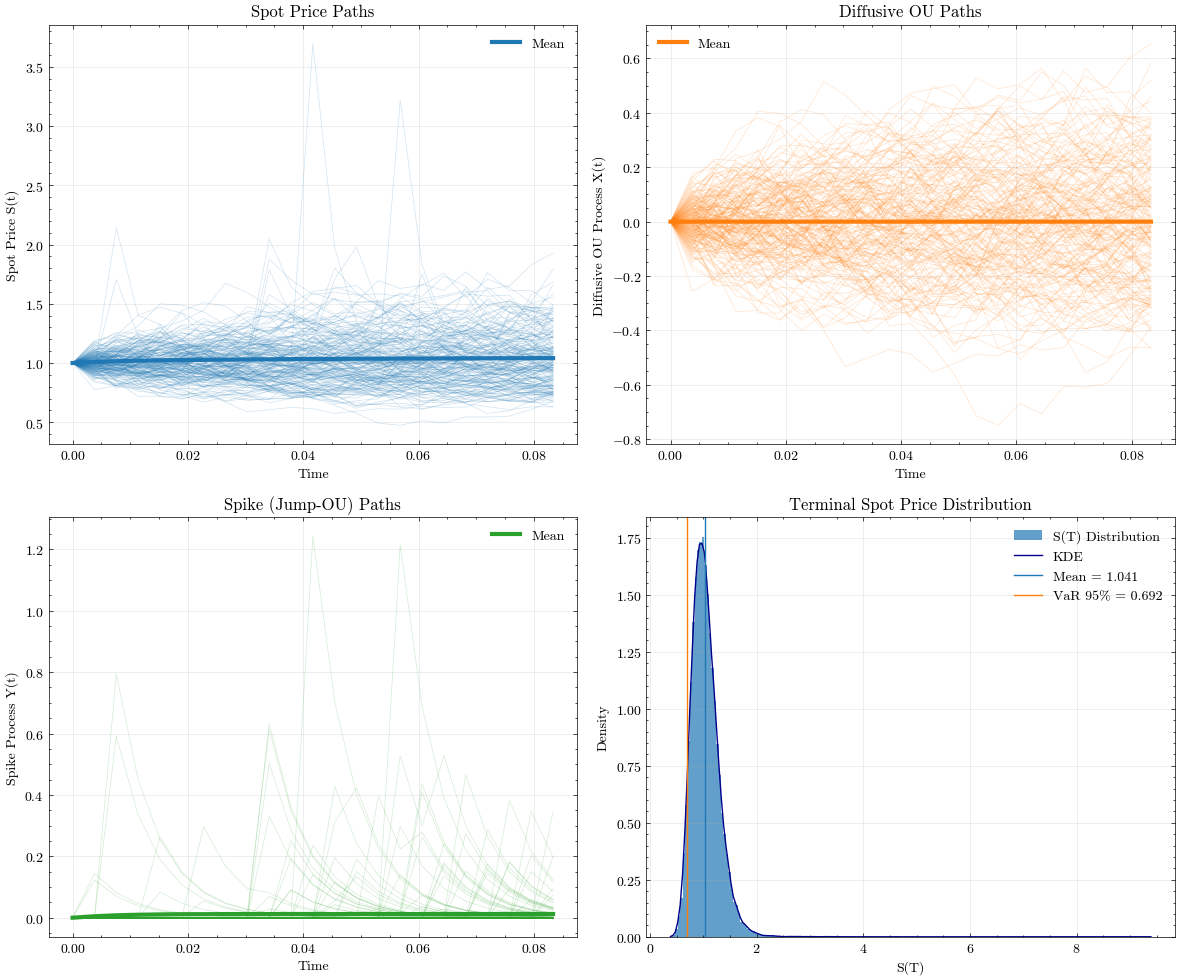

Simulation Summary:
Number of paths: 65,536
Number of time steps: 23
Time horizon: 0.1 years

Terminal Statistics S(T):
Mean: 1.0413
Std: 0.2592
Min: 0.3860
Max: 9.3934
VaR 95%: 0.6916
VaR 99%: 0.5908


In [7]:
"""
    Hambly–Howison–Kluge spot model with antithetic variance reduction.
    
    Note: Antithetic variance reduction is only applied when n_paths >= 2 and n_paths is even.
    For single path generation (n_paths=1), standard simulation is used.

    Returns
    -------
    t : (n_steps+1,) ndarray     time grid
    S : (n_paths, n_steps+1)     spot price paths
    X : (n_paths, n_steps+1)     diffusive OU paths
    Y : (n_paths, n_steps+1)     spike (jump‑OU) paths
"""
stochastic_process_params = {
    'S0': 1.0,          # Initial spot price
    'T': 1/12,           # Time horizon
    'n_steps': 22,     # Number of time steps
    'n_paths': 16384*4, # Number of paths (should be even for antithetic variance reduction)
    'alpha': 12.0,      # Mean reversion speed
    'sigma': 1.2,       # Volatility of the diffusive component
    'beta': 150.0,      # Mean reversion level for the OU process
    'lam': 6.0,         # Intensity of the jump process
    'mu_J': 0.3,        # Mean of the jump size distribution
    'f': lambda t: 0.0,  # Function for the drift term (can be a constant or a function of time)
}
# Simulate the HHK spot model
t, S, X, Y = simulate_hhk_spot( 
    **stochastic_process_params,
    seed=1,
)
print('Simulation Completed')

# ========================================================================
# ========================================================================

# Moments of S(T)
mean_results, std_results = bootstrap_moments(S[:, -1])

desired_keys = ['S0','T','alpha','sigma','beta','lam','mu_J','f']
subset_params = {key: stochastic_process_params[key] for key in desired_keys if key in stochastic_process_params}
mZ, sZ, mX, sX, mY, sY = theoretical_moments(**subset_params)

print('> S(T) moments:')
print(f'E[S(T)] = {mean_results[0]:.4f} (empirical), {mZ:.4f} (analytical), bounds: [{mean_results[1]:.4f}, {mean_results[2]:.4f}]')
print(f'Std[S(T)] = {std_results[0]:.4f} (empirical), {sZ:.4f} (analytical), bounds: [{std_results[1]:.4f}, {std_results[2]:.4f}]')

# Moments of X(T)
mean_results_X, std_results_X = bootstrap_moments(X[:, -1])

print('\n> X(T) moments:')
print(f'E[X(T)] = {mean_results_X[0]:.4f} (empirical), {mX:.4f} (analytical), bounds: [{mean_results_X[1]:.4f}, {mean_results_X[2]:.4f}]')
print(f'Std[X(T)] = {std_results_X[0]:.4f} (empirical), {sX:.4f} (analytical), bounds: [{std_results_X[1]:.4f}, {std_results_X[2]:.4f}]')

# Moments of Y(T)
mean_results_Y, std_results_Y = bootstrap_moments(Y[:, -1])

print('\n> Y(T) moments:')
print(f'E[Y(T)] = {mean_results_Y[0]:.4f} (empirical), {mY:.4f} (analytical), bounds: [{mean_results_Y[1]:.4f}, {mean_results_Y[2]:.4f}]')
print(f'Std[Y(T)] = {std_results_Y[0]:.4f} (empirical), {sY:.4f} (analytical), bounds: [{std_results_Y[1]:.4f}, {std_results_Y[2]:.4f}]')

# ========================================================================
# ========================================================================

# Plot the simulated spot price paths - Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:blue']
n_plot_paths = 200

# Plot data for S, X, Y with means
for i, (data, label, ylabel) in enumerate([(S, 'Spot Price Paths', 'Spot Price S(t)'), 
                                           (X, 'Diffusive OU Paths', 'Diffusive OU Process X(t)'), 
                                           (Y, 'Spike (Jump-OU) Paths', 'Spike Process Y(t)')]):
    ax = axes.flat[i]
    for j in range(min(n_plot_paths, data.shape[0])):
        ax.plot(t, data[j, :], color=colors[i], alpha=0.2, linewidth=0.5)
    ax.plot(t, np.mean(data, axis=0), color=colors[i], linewidth=3, label='Mean', alpha=1.0)
    ax.set_xlabel('Time')
    ax.set_ylabel(ylabel)
    ax.set_title(label)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot S(T) distribution
ax = axes[1, 1]
S_T = S[:, -1]
ax.hist(S_T, bins=200, density=True, alpha=0.7, color=colors[3], label='S(T) Distribution')
kde = gaussian_kde(S_T)
x_kde = np.linspace(S_T.min(), S_T.max(), 200)
ax.plot(x_kde, kde(x_kde), color='darkblue', linewidth=1, label='KDE')
S_T_mean = np.mean(S_T)
var_95 = np.percentile(S_T, 5)
ax.axvline(S_T_mean, color='tab:blue', linestyle='-', linewidth=1, label=f'Mean = {S_T_mean:.3f}')
ax.axvline(var_95, color='tab:orange', linestyle='-', linewidth=1, label=f'VaR 95% = {var_95:.3f}')
ax.set_xlabel('S(T)')
ax.set_ylabel('Density')
ax.set_title('Terminal Spot Price Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Simulation Summary:\nNumber of paths: {S.shape[0]:,}\nNumber of time steps: {S.shape[1]}\nTime horizon: {t[-1]:.1f} years")
print(f"\nTerminal Statistics S(T):\nMean: {S_T_mean:.4f}\nStd: {np.std(S_T):.4f}\nMin: {S_T.min():.4f}\nMax: {S_T.max():.4f}\nVaR 95%: {var_95:.4f}\nVaR 99%: {np.percentile(S_T, 1):.4f}")

# 